## Fit hanger S21
This notebook fits hanger resonance.

In [1]:
%matplotlib notebook
import qcodes as qc
import numpy as np
import sys, os
sys.path.append("..")
from analysis.characterizations.characterizations import resonators as res
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import load_by_id
from analysis.characterizations.characterizations.fitter import fit

import matplotlib.pyplot as plt

C:\ProgramData\Anaconda2\envs\qcodes\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# calculate Lk

Before simulating in AWR Microwave office we need an estimate (sample specific) of the kinetic inductance $L_k$ via anunziata et al.(2010)
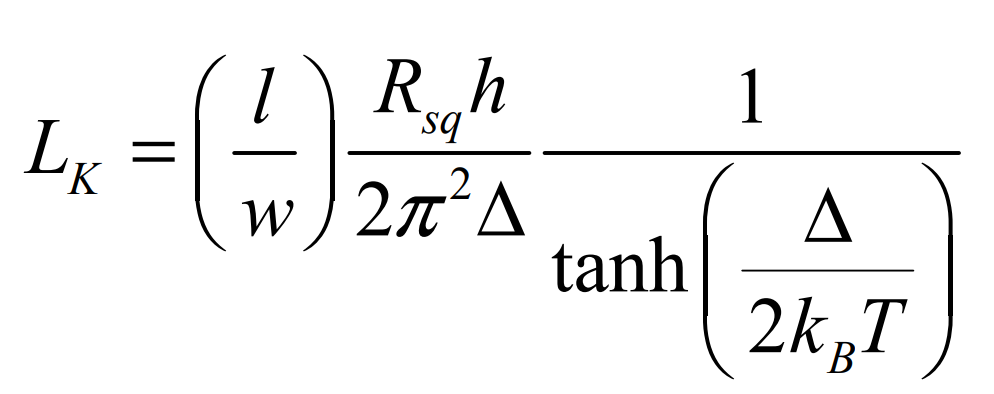

<IPython.core.display.Javascript object>


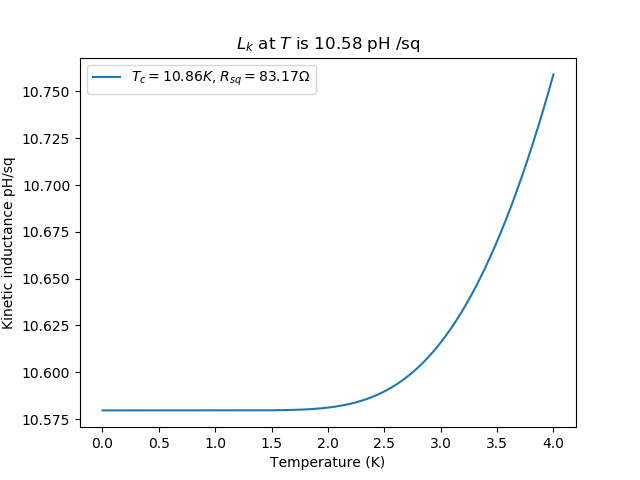

$L_k$ at $T~0$ is 10.58 pH /sq
83.17073170731706


In [2]:
#fill in these values
Tc = 10.86 #critical temperature in K
R = 21.7e3 #measured resistance of feedline
w = 22e-6 #width of feeldine
l = 5740e-6 #length of feedline

# values needed for formula
Rs = R * (w/l) #83.17 #resistance per square in ohm
kb = 1.38064852e-23 #boltzmann constant
h = 6.62607004e-34 #planck constant
Delta_0 = 1.76 * kb * Tc

T = np.linspace(1e-3,4,1000)

L_k =  Rs * h /(2 * np.pi**2 * Delta_0 * np.tanh(Delta_0/(2*kb*T)))
plt.figure()
plt.plot(T,L_k * 1e12)
plt.title("$L_k$ at $T~0$ is %.2f pH /sq" %(L_k[0] *1e12))
plt.legend(["$T_c=%.2f K$, $R_{sq} = %.2f \Omega$" % (Tc, Rs)])
plt.xlabel('Temperature (K)')
plt.ylabel('Kinetic inductance pH/sq')
print("$L_k$ at $T~0$ is %.2f pH /sq" %(L_k[0] *1e12))
print(Rs)

### loading data
Qcodes data loading. Set the database path and do some hacky reshaping to get the right data array back.

In [4]:
dbpath = r"D:\data\181214 SR001\experiments.db"

qc.initialise_database()
qc.dataset.database.initialise_or_create_database_at(dbpath)
qc.dataset.database.get_DB_location()
"""
Loads data given that there is some second parameter that you sweep over. In the case of 18-12-2018 this was the power. 
params:
    Npoints reshapes the data again by the amount of averages per trace. e.g creates a 3rd dimension
    load_temperature: Added as optional because sometimes the T measurement didn't work so to save time in the fridge i didnt save it
    
"""
def load_data(id_data, Npoints, load_temperature=True, correct_cut_off_data=True):
    ds1=qc.load_by_id(id_data)
    print(ds1.get_parameters())
    f1=np.array(ds1.get_values("frequency"))
    n_sweep = np.argmax(f1)+1 #amount of points per single trace
    if correct_cut_off_data:
        i_max = int(np.floor(np.shape(f1)[0] / (Npoints * n_sweep)) * (Npoints * n_sweep))
        print(i_max)
    else:
         i_max = -1   
    f1=f1[0:i_max].reshape(-1,Npoints,n_sweep)
    #hp1=np.array(ds1.get_values("heater_power"))
    #hp1=hp1.reshape(-1,np.argmax(f1)+1)
    P1=np.array(ds1.get_values("Pow_S21"))[0:i_max]
    P1=P1.reshape(-1,Npoints,n_sweep)
    phase1=np.array(ds1.get_values("Phase_S21"))[0:i_max]
    phase1=phase1.reshape(-1,Npoints,n_sweep)
    S21 = (np.array(ds1.get_values("Re_S21")) + 1j * np.array(ds1.get_values("Im_S21")))[0:i_max]
    S21 = S21.reshape(-1,Npoints,n_sweep)
    if load_temperature:
        T = np.array(ds1.get_values("temperature"))[0:i_max]
        T = T.reshape(-1,Npoints,n_sweep)
        return f1, P1, phase1, S21, T
    else:        
        return f1, P1, phase1, S21




## fitting and plotting single sweep

In [142]:
print(np.shape(freqs))
print(np.shape(S21_avg))

(7000,)
(7000,)


[ParamSpec('vna_power', 'numeric', 'P', 'dB', inferred_from=[], depends_on=[]), ParamSpec('frequency', 'numeric', 'frequency', 'MHz', inferred_from=[], depends_on=[]), ParamSpec('temperature', 'numeric', 'T', 'K', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Re_S21', 'numeric', 'Re_S21', 'V', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Im_S21', 'numeric', 'Im_S21', 'V', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Pow_S21', 'numeric', 'Pow_S21', 'dBm', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Phase_S21', 'numeric', 'Phase_S21', 'deg.', inferred_from=[], depends_on=['vna_power', 'frequency'])]
210030
(2, 15, 7001)
[[Variables]]
    f0:      5535.24896 +/- 0.006020 (0.00%) (init= 5534.326)
    Q:       2731.39305 +/- 16.21173 (0.59%) (init= 1729.724)
    Qe:      2293.78148 +/- 9.804780 (0.43%) (init= 1902.031)
    A:       6.10048678 +/- 0.003024 (0.05%) (init= 6.295476)
    theta:  -0.8

<IPython.core.display.Javascript object>


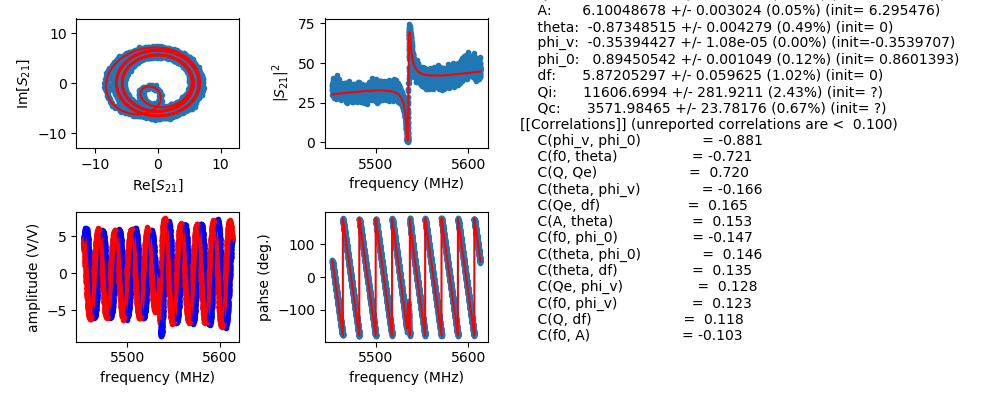

11606.699489444718  +-  281.92114121911743
2293.7814889399815  +-  9.8047804856343


In [146]:
%matplotlib notebook
#load the data
N = 15
f, P, phase, S21, T = load_data(82, N)
print(np.shape(f))

#preprocess data a bit to make fit quicker and better(shouldnt have too many points away from the peak)
#set minimum and maximum index around the expected peak to shorten data. 
i_min = 0
i_max = -1

p_ind = 0
freqs = f[0,0,i_min:i_max]
S21_avg = np.mean(S21, axis=1)[p_ind,i_min:i_max]

Qi = np.zeros(len(powers))
Qc = np.zeros(len(powers))
Qi_err = np.zeros(len(powers))
Qc_err = np.zeros(len(powers))

# use gijs fitting functions
pars, result, hanger_model, fit_report = res.fit_hanger(freqs, S21_avg, True) #p0_sloped)
res.plot_results(S21_avg, pars, hanger_model, fit_report, result, resolution = 0.05, figlab = '')
# get the Qs!
Qi[p_ind] = pars['Qi'].value
Qc[p_ind] = pars['Qe'].value
Qi_err[p_ind] = pars['Qi'].stderr
Qc_err[p_ind] = pars['Qe'].stderr

print(pars['Qi'].value, ' +- ', pars['Qi'].stderr)
print(pars['Qe'].value,' +- ', pars['Qe'].stderr)


### Fitting and Plotting single power sweep

In [52]:
np.zeros(len(powers))

array([0., 0., 0., 0., 0.])

In [101]:
#load the data
N = 15
f, P, phase, S21, T = load_data(84, N)
print(np.shape(f))

#preprocess data a bit to make fit quicker and better(shouldnt have too many points away from the peak)
powers = np.array([-60,-50,-40,-30,-20])
#set minimum and maximum index around the expected peak to shorten data. 
i_min = 2800
i_max = 4700

Qi = np.zeros(len(powers))
Qc = np.zeros(len(powers))
Qi_err = np.zeros(len(powers))
Qc_err = np.zeros(len(powers))
#

for p_ind in range(0,len(powers)):
    
    freqs = f[0,0,i_min:i_max]
    S21_avg = np.mean(S21, axis=1)[p_ind,i_min:i_max]

    # use gijs fitting functions
    pars, result, hanger_model, fit_report = res.fit_hanger(freqs, S21_avg, True) #p0_sloped)
    res.plot_results(S21_avg, pars, hanger_model, fit_report, result, resolution = 0.05, figlab = '')
    # get the Qs!
    Qi[p_ind] = pars['Qi'].value
    Qc[p_ind] = pars['Qe'].value
    Qi_err[p_ind] = pars['Qi'].stderr
    Qc_err[p_ind] = pars['Qe'].stderr
    
    print(pars['Qi'].value, ' +- ', pars['Qi'].stderr)
    print(pars['Qe'].value,' +- ', pars['Qe'].stderr)
   

[ParamSpec('vna_power', 'numeric', 'P', 'dB', inferred_from=[], depends_on=[]), ParamSpec('frequency', 'numeric', 'frequency', 'MHz', inferred_from=[], depends_on=[]), ParamSpec('temperature', 'numeric', 'T', 'K', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Re_S21', 'numeric', 'Re_S21', 'V', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Im_S21', 'numeric', 'Im_S21', 'V', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Pow_S21', 'numeric', 'Pow_S21', 'dBm', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Phase_S21', 'numeric', 'Phase_S21', 'deg.', inferred_from=[], depends_on=['vna_power', 'frequency'])]
(5, 15, 7001)
[[Variables]]
    f0:      5132.90555 +/- 0.005074 (0.00%) (init= 5133.343)
    Q:       2082.76297 +/- 8.583871 (0.41%) (init= 5913.211)
    Qe:      2239.06845 +/- 6.927084 (0.31%) (init= 6714.982)
    A:       10.1383143 +/- 0.006275 (0.06%) (init= 9.953755)
    theta:   0.42534338

<IPython.core.display.Javascript object>


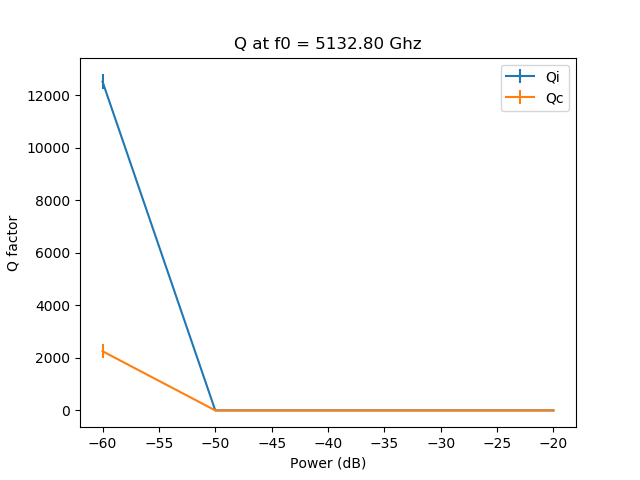

Text(0, 0.5, 'Q factor')

In [114]:
plt.figure()
plt.title('Q at f0 = %.2f Ghz' % pars['f0'].value)
plt.errorbar(powers,Qi, yerr=Qi_err, label='Qi')
plt.errorbar(powers,Qc, yerr=Qi_err, label='Qc')
plt.legend()
plt.xlabel('Power (dB)')
plt.ylabel('Q factor')

# fitting plotting all resonators in one graph

In [104]:
#
Qis = []
Qcs = []
Qi_errs = []
Qc_errs = []
pars_list = []
powers = np.array([-60,-50,-40,-30,-20])
#data ids 18-12-18 
data_ids = [82,83,84,85,87]
for data_id in data_ids:
    if(data_id == 86):
        powers = np.array([-60,-50])
    if(data_id == 87):
        powers = np.array([-60])
    #load the data
    N = 15
    f, P, phase, S21, T = load_data(data_id, N)
    print(np.shape(f))

    #preprocess data a bit to make fit quicker and better(shouldnt have too many points away from the peak)
    #set minimum and maximum index around the expected peak to shorten data. 
    i_min = 2800
    i_max = 4700

    Qi = np.zeros(len(powers))
    Qc = np.zeros(len(powers))
    Qi_err = np.zeros(len(powers))
    Qc_err = np.zeros(len(powers))
    #
    pars_l = []
    for p_ind in range(0,len(powers)):
       
        freqs = f[0,0,i_min:i_max]
        S21_avg = np.mean(S21, axis=1)[p_ind,i_min:i_max]

        # use gijs fitting functions
        pars, result, hanger_model, fit_report = res.fit_hanger(freqs, S21_avg, True) #p0_sloped)
        res.plot_results(S21_avg, pars, hanger_model, fit_report, result, resolution = 0.05, figlab = '')
        # get the Qs!
        Qi[p_ind] = pars['Qi'].value
        Qc[p_ind] = pars['Qe'].value
        Qi_err[p_ind] = pars['Qi'].stderr
        Qc_err[p_ind] = pars['Qe'].stderr

        print(pars['Qi'].value, ' +- ', pars['Qi'].stderr)
        print(pars['Qe'].value,' +- ', pars['Qe'].stderr)
        pars_l.append(pars)
        
    Qis.append(Qi)
    Qcs.append(Qc)
    Qi_errs.append(Qi_err)
    Qc_errs.append(Qc_err)
    pars_list.append(pars_l)

[ParamSpec('vna_power', 'numeric', 'P', 'dB', inferred_from=[], depends_on=[]), ParamSpec('frequency', 'numeric', 'frequency', 'MHz', inferred_from=[], depends_on=[]), ParamSpec('temperature', 'numeric', 'T', 'K', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Re_S21', 'numeric', 'Re_S21', 'V', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Im_S21', 'numeric', 'Im_S21', 'V', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Pow_S21', 'numeric', 'Pow_S21', 'dBm', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Phase_S21', 'numeric', 'Phase_S21', 'deg.', inferred_from=[], depends_on=['vna_power', 'frequency'])]
(5, 15, 7001)
[[Variables]]
    f0:      4642.48229 +/- 0.002397 (0.00%) (init= 4642.331)
    Q:       3768.13812 +/- 14.66759 (0.39%) (init= 5347.604)
    Qe:      4266.95705 +/- 12.04593 (0.28%) (init= 6158.474)
    A:       15.3483408 +/- 0.005716 (0.04%) (init= 15.09152)
    theta:  -0.26722564

ValueError: x and y must have same first dimension, but have shapes (1898,) and (1900,)

In [86]:
powers = np.array([-60,-50,-40,-30,-20])

<IPython.core.display.Javascript object>


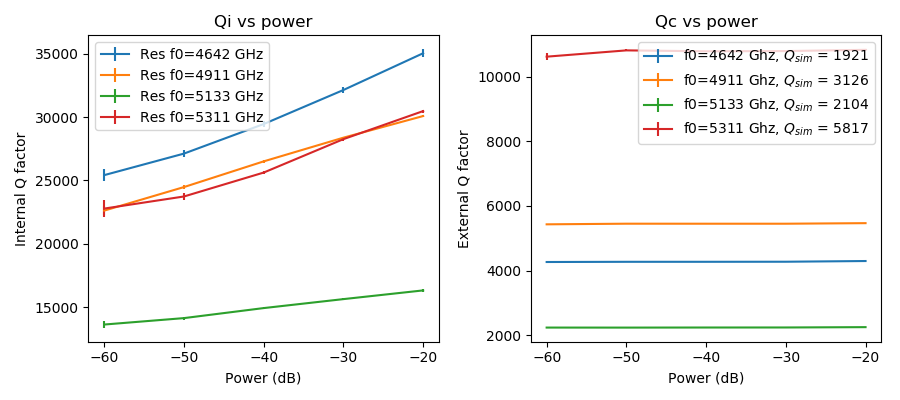

In [99]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.title('Qi vs power')
Q_target = [1921,3126,2104,5817]
for i in range(len(Qis)-1):
    plt.errorbar(powers[0:Qis[i].shape[0]],Qis[i], fmt='-', yerr=Qi_errs[i], label='Res f0=%.0f GHz' % pars_list[i][0]['f0'].value)
plt.legend(loc='best')
plt.xlabel('Power (dB)')
plt.ylabel('Internal Q factor')
plt.subplot(1,2,2)
plt.title('Qc vs power')
for i in range(len(Qis)-1):
    plt.errorbar(powers[0:Qis[i].shape[0]],Qcs[i],fmt='-', yerr=Qc_errs[i], label='f0=%.0f Ghz, $Q_{sim}$ = %d' % (pars_list[i][0]['f0'].value, Q_target[i]))
plt.legend(loc='best')
plt.xlabel('Power (dB)')
plt.ylabel('External Q factor')
plt.tight_layout()

In [103]:
print(Qcs)

[array([4266.95705279, 4273.1169461 , 4273.44238666, 4275.42844212,
       4297.2167797 ]), array([5432.383979  , 5451.78168692, 5451.17149501, 5451.25644578,
       5468.58501599]), array([2239.06845681, 2238.15681211, 2240.78785848, 2242.00106569,
       2252.34605588]), array([10618.024144  , 10812.43673262, 10784.44023128, 10791.08096632,
       10829.38355038]), array([802.96666788])]


### testing the vf slope parameter

found out that fitting didn't work so checked how to find vf

<IPython.core.display.Javascript object>


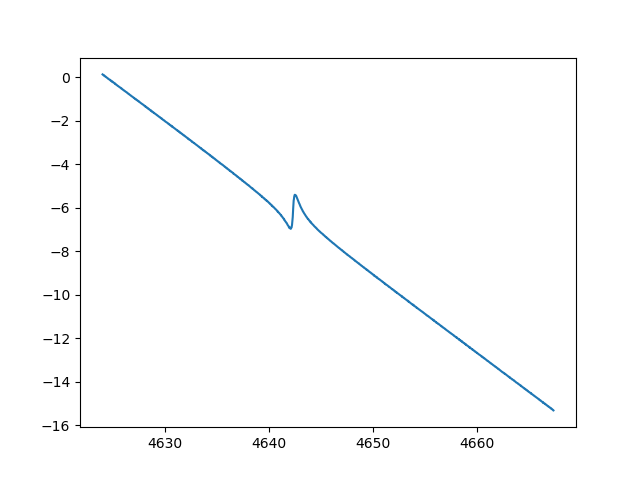

-0.35568582578260405
-0.39269908169872414


In [22]:
plt.figure()
plt.plot(freqs,np.unwrap(np.angle(S21_avg)))
print(np.mean(np.diff(np.unwrap(np.angle(S21_avg)))) / np.mean(np.diff(freqs)))
print(-np.pi/8)

# legacy code where i tried to debug the fitting of gijs on my own. Found the problem in vf

[ParamSpec('vna_power', 'numeric', 'P', 'dB', inferred_from=[], depends_on=[]), ParamSpec('frequency', 'numeric', 'frequency', 'MHz', inferred_from=[], depends_on=[]), ParamSpec('temperature', 'numeric', 'T', 'K', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Re_S21', 'numeric', 'Re_S21', 'V', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Im_S21', 'numeric', 'Im_S21', 'V', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Pow_S21', 'numeric', 'Pow_S21', 'dBm', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Phase_S21', 'numeric', 'Phase_S21', 'deg.', inferred_from=[], depends_on=['vna_power', 'frequency'])]
525075
(5, 15, 7001)
(5001,)


<IPython.core.display.Javascript object>


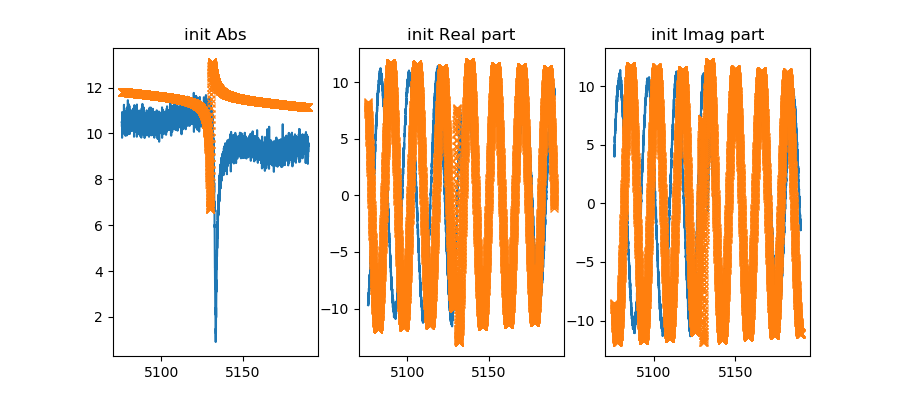

[[Variables]]
    f0:      5132.82602 +/- 0.006944 (0.00%) (init= 5130.3)
    Q:       2724.96301 +/- 13.80266 (0.51%) (init= 5000)
    A:       9.94251654 +/- 0.005468 (0.06%) (init= 11.5)
    theta:   0.48862945 +/- 0.005309 (1.09%) (init=-0.2617994)
    phi_v:  -0.35601473 +/- 1.65e-05 (0.00%) (init=-0.3926991)
    phi_0:  -3.55068500 +/- 0.001033 (0.03%) (init=-0.7853982)
    df:     -6.60482516 +/- 0.085908 (1.30%) (init=-3)
[[Correlations]] (unreported correlations are <  0.100)
    C(phi_v, phi_0)              = -0.848 
    C(f0, theta)                 = -0.727 
    C(theta, df)                 =  0.213 
    C(f0, df)                    = -0.153 
    C(theta, phi_v)              =  0.126 
    C(Q, A)                      = -0.106 
    C(A, theta)                  = -0.104 


<IPython.core.display.Javascript object>


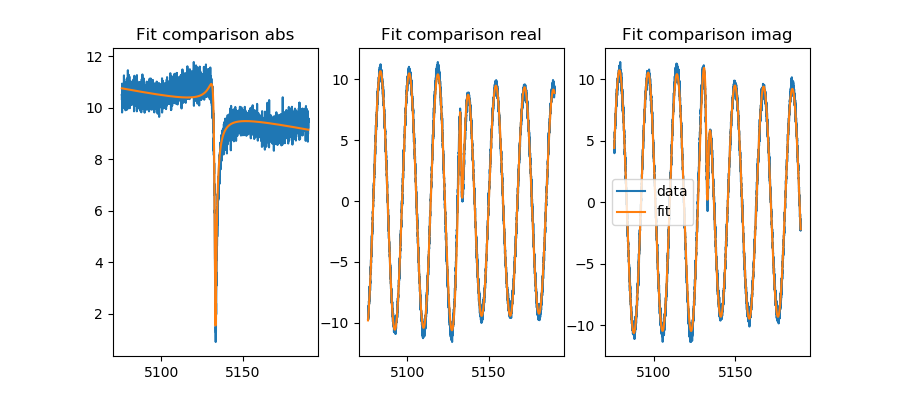

15999.330581182461  +-  522.1509885591679
2900.0  +-  0


In [39]:
#load the data
N = 15
f, P, phase, S21, T = load_data(84, N)
print(np.shape(f))

powers = np.array([60,50,40,30,20])
p_ind = 1 #power index see array above. 
i_min = 1000
i_max = -1000
freqs = f[0,0,i_min:i_max]
S21_avg =S21[p_ind,2,i_min:i_max]#np.mean(S21, axis=1)[p_ind,i_min:i_max]

print(S21_avg.shape)

#now let's get the hanger model thingy
f0 = 5130.3
Q = 5000.
Qe = 2900.
A = 11.5
theta = -np.pi / 12

phi_v = -np.pi/8
phi_0 = -np.pi/4
df = -3

p0 = [freqs,f0,Q,Qe,A,theta]

p0_sloped = [freqs,f0,Q,Qe,A,theta,phi_v,phi_0,df]
plt.figure(figsize=(9,4))
plt.subplot(1,3,1)
plt.title('init Abs')
plt.plot(freqs,np.abs(S21_avg))
#plt.plot(freqs, np.abs(res.hanger_S21(freqs,f0,Q,Qe,A,theta)))
plt.plot(freqs, np.abs(res.hanger_S21_sloped(freqs,f0,Q,Qe,A,theta, phi_v,phi_0, df)),'x')

plt.subplot(1,3,2)
plt.title('init Real part')
plt.plot(freqs,np.real(S21_avg))
#plt.plot(freqs, np.real(res.hanger_S21(freqs,f0,Q,Qe,A,theta)))
plt.plot(freqs, np.real(res.hanger_S21_sloped(freqs,f0,Q,Qe,A,theta, phi_v,phi_0, df)), 'x')

plt.subplot(1,3,3)
plt.title('init Imag part')
plt.plot(freqs,np.imag(S21_avg))
#plt.plot(freqs, np.imag(res.hanger_S21(freqs,f0,Q,Qe,A,theta)))
plt.plot(freqs, np.imag(res.hanger_S21_sloped(freqs,f0,Q,Qe,A,theta, phi_v,phi_0, df)), 'x')

hanger_model, pars = fit.make_model(res.hanger_S21_sloped,  p0 = tuple(p0_sloped))
pars['f'].vary = False
#pars['df'].vary = False
pars['Q'].min = 0
pars['Qe'].min = 0
pars['A'].vary=True
pars['Q'].vary = True
pars['Qe'].vary=False
pars['df'].vary=True
pars['f0'].vary = True
pars['theta'].vary=True
pars['phi_0'].vary=True
pars.add('Qi', expr = '1/(1/Q-abs(1/Qe)*cos(theta))')
pars.add('Qc', expr = 'abs(Qe/cos(theta))')

result,  fitted_values= fit.fit(pars, S21_avg, hanger_model)
fit_report = fit.print_fitres(pars)

plt.figure(figsize=(9,4))
plt.subplot(1,3,1)
plt.title('Fit comparison abs')
plt.plot(freqs, np.abs(S21_avg), label='data')
plt.plot(freqs, np.abs(res.hanger_S21_sloped(*[pars[key].value for key in pars.valuesdict()][0:9])), label='fit')
plt.subplot(1,3,2)
plt.title('Fit comparison real')
plt.plot(freqs, S21_avg.real, label='data')
plt.plot(freqs, res.hanger_S21_sloped(*[pars[key].value for key in pars.valuesdict()][0:9]).real, label='fit')
plt.subplot(1,3,3)
plt.title('Fit comparison imag')
plt.plot(freqs, S21_avg.imag, label='data')
plt.plot(freqs, res.hanger_S21_sloped(*[pars[key].value for key in pars.valuesdict()][0:9]).imag, label='fit')
plt.legend()

print(pars['Qi'].value, ' +- ', pars['Qi'].stderr)
print(pars['Qe'].value,' +- ', pars['Qe'].stderr)
#print(pars['Qi_verify'].value, ' +- ', pars['Qi_verify'].stderr)

In [30]:
print(pars['Qi'].value, ' +- ', pars['Qi'].stderr)
print(pars['Q'].value,' +- ', pars['Qe'].stderr)


15714.060315137916  +-  451.08001974232184
2360.823740909095  +-  0


[[Variables]]
    f0:      4642.47744 +/- 0.001122 (0.00%) (init= 4642.309)
    Q:       3804.12136 +/- 6.998143 (0.18%) (init= 5347.578)
    Qe:      4273.11694 +/- 5.698549 (0.13%) (init= 6278.63)
    A:       15.3434813 +/- 0.002709 (0.02%) (init= 15.24442)
    theta:  -0.26268745 +/- 0.001332 (0.51%) (init= 0)
    phi_v:  -0.35685621 +/- 1.37e-05 (0.00%) (init=-0.3556858)
    phi_0:   0.16468032 +/- 0.000344 (0.21%) (init= 0.1315734)
    df:     -2.79871628 +/- 0.063255 (2.26%) (init= 0)
    Qi:      27115.3068 +/- 249.5855 (0.92%) (init= ?)
    Qc:      4424.91087 +/- 6.110513 (0.14%) (init= ?)
[[Correlations]] (unreported correlations are <  0.100)
    C(phi_v, phi_0)              = -0.869 
    C(Q, Qe)                     =  0.740 
    C(f0, theta)                 = -0.740 
    C(Qe, phi_v)                 =  0.279 
    C(theta, df)                 =  0.278 
    C(A, df)                     = -0.266 
    C(Q, A)                      = -0.225 
    C(Q, phi_v)                  =  

<IPython.core.display.Javascript object>


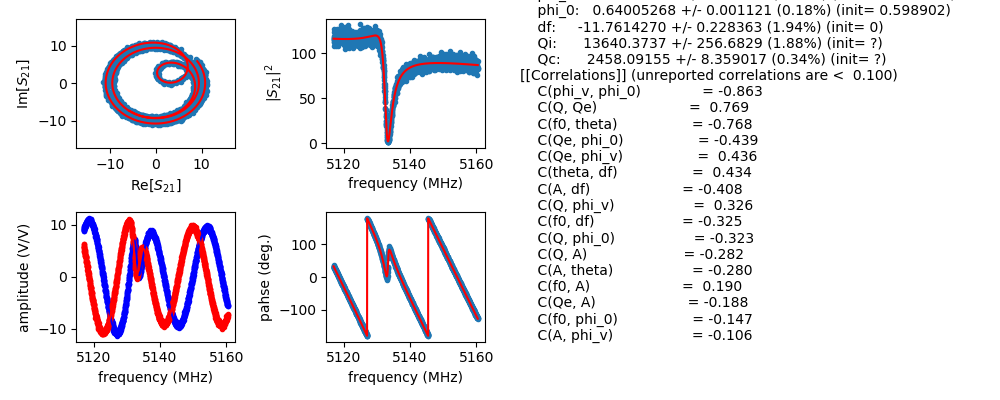

27115.306811128226  +-  249.58555117121628
4273.116946099114  +-  5.698549891446314


In [28]:
import importlib
importlib.reload(res)
pars, result, hanger_model, fit_report = res.fit_hanger(freqs, S21_avg, True) #p0_sloped)
res.plot_results(S21_avg, pars, hanger_model, fit_report, result, resolution = 0.05, figlab = '')

print(pars['Qi'].value, ' +- ', pars['Qi'].stderr)
print(pars['Qe'].value,' +- ', pars['Qe'].stderr)


In [ ]:
plt.figure()
plt.plot(f[0,i_min:i_max], S21_norm.real)
plt.plot(f[0,i_min:i_max], S21_norm.imag)
pars, results, hanger_model, fit_report = res.fit_hanger(f[0,i_min:i_max], S21_norm, display_report = False)
res.plot_results(S21_norm, pars, hanger_model, fit_report, results, figlab = 'power = %.0f'%(-60))
       

In [153]:
np.shape(f)
plt.figure()
plt.plot(f[0,:], P[0,:])

In [19]:
runid = 82
pars_list, Ps = fit_hanger_p_dep(runid)
plot_Qs(pars_list, Ps)

ValueError: cannot reshape array of size 525075 into shape (525075,7001)

In [103]:
i_min=3000
i_max=4000
S21_norm = np.mean(S21[0:15,i_min:i_max],axis=0)
ydat = S21_norm
xdat = f[0,i_min:i_max]
s21 = np.abs(ydat)
A = (np.abs(s21[0]) + np.abs(s21[-1]))/2.
f0 = xdat[np.argmin(s21)]
s21min = np.abs(np.min(s21)/A)
print('s21min: ',s21min)
FWHM = np.abs(xdat[-1] - xdat[0])/50.
Ql = f0/FWHM
Qi = Ql/(s21min)
Qc = Ql/np.abs(1-s21min)

#print('Qc: ', Qc)
phi_0 = np.angle(ydat[0])
avg_ang = np.average( np.diff(np.angle(ydat)) )
avg_ang = np.diff(np.angle(ydat))

phi_v = -np.average((avg_ang[np.abs(avg_ang)<np.pi/4]))/(np.diff(xdat)[0])

p0 = [xdat, f0, Ql, Qc, A, 0., phi_v, phi_0, 0.]

s21min:  0.13091213908374924


In [104]:
S21init = res.hanger_S21_sloped(*p0)
plt.figure()
plt.plot(f[0,i_min:i_max],np.abs(S21_norm), 'x')
plt.plot(f[0,i_min:i_max],np.abs(S21init))
plt.legend(['init param fit', 'data'])

In [75]:
f0

4642.33142857143

In [76]:
Qi

10907.218893563928

In [77]:
Qc

1673.286128859027

# Comparison of Qi vs corrected Qi

[ParamSpec('vna_power', 'numeric', 'P', 'dB', inferred_from=[], depends_on=[]), ParamSpec('frequency', 'numeric', 'frequency', 'MHz', inferred_from=[], depends_on=[]), ParamSpec('temperature', 'numeric', 'T', 'K', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Re_S21', 'numeric', 'Re_S21', 'V', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Im_S21', 'numeric', 'Im_S21', 'V', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Pow_S21', 'numeric', 'Pow_S21', 'dBm', inferred_from=[], depends_on=['vna_power', 'frequency']), ParamSpec('Phase_S21', 'numeric', 'Phase_S21', 'deg.', inferred_from=[], depends_on=['vna_power', 'frequency'])]
525075
(5, 15, 7001)
[[Variables]]
    f0:      5132.79864 +/- 0.005855 (0.00%) (init= 5133.343)
    Q:       2134.21165 +/- 10.38110 (0.49%) (init= 1604.399)
    Qe:      2251.79661 +/- 7.872451 (0.35%) (init= 1821.06)
    A:       9.92757760 +/- 0.003491 (0.04%) (init= 9.989306)
    theta:   0.50

<IPython.core.display.Javascript object>


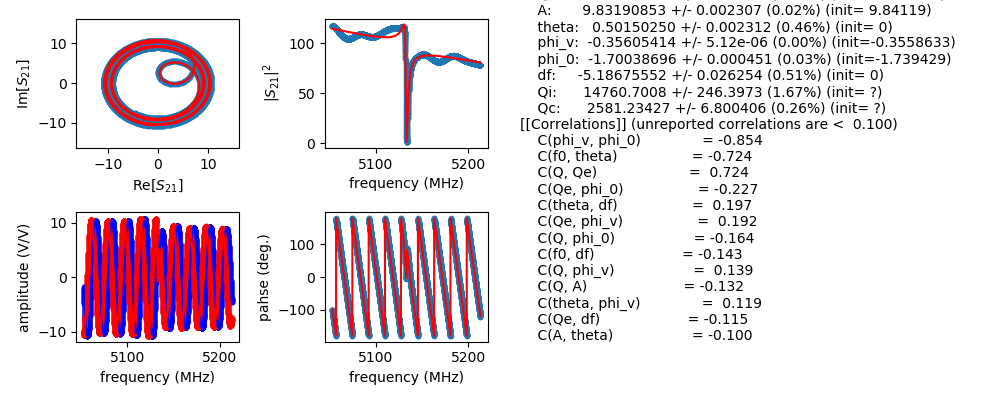

Qi:  12516.186214705564  +-  275.7066121747591
Qi_verify:  12516.186214705564  +-  275.7066121747591
Qe:  2251.796612893475  +-  7.8724514660808325
Q:  2134.211657844307  +-  10.381101838071357
Qc:  2572.939317552192  +-  10.281493350572271
[[Variables]]
    f0:      5132.79610 +/- 0.004138 (0.00%) (init= 5133.411)
    Q:       2144.18936 +/- 7.406188 (0.35%) (init= 1604.42)
    Qe:      2248.84705 +/- 5.582428 (0.25%) (init= 1827.182)
    A:       9.92518000 +/- 0.002488 (0.03%) (init= 9.942756)
    theta:   0.50748885 +/- 0.002486 (0.49%) (init= 0)
    phi_v:  -0.35605256 +/- 5.47e-06 (0.00%) (init=-0.3558457)
    phi_0:  -1.69750318 +/- 0.000481 (0.03%) (init=-1.731287)
    df:     -5.29233734 +/- 0.028042 (0.53%) (init= 0)
    Qi:      12862.1474 +/- 206.0815 (1.60%) (init= ?)
    Qc:      2573.14681 +/- 7.310983 (0.28%) (init= ?)
[[Correlations]] (unreported correlations are <  0.100)
    C(phi_v, phi_0)              = -0.854 
    C(f0, theta)                 = -0.725 
    C(Q, Qe

In [12]:
%matplotlib notebook
#load the data
N = 15
f, P, phase, S21, T = load_data(84, N)
print(np.shape(f))

#preprocess data a bit to make fit quicker and better(shouldnt have too many points away from the peak)
#set minimum and maximum index around the expected peak to shorten data. 
i_min = 0
i_max = -1

for p_ind in range(0,5):
    freqs = f[0,0,i_min:i_max]
    S21_avg = np.mean(S21, axis=1)[p_ind,i_min:i_max]


    # use gijs fitting functions
    pars, result, hanger_model, fit_report = res.fit_hanger(freqs, S21_avg, True) #p0_sloped)
    res.plot_results(S21_avg, pars, hanger_model, fit_report, result, resolution = 0.05, figlab = '')
    # get the Qs!

    print("Qi: " ,pars['Qi'].value, ' +- ', pars['Qi'].stderr)
    print("Qi_verify: " ,pars['Qi_verify'].value, ' +- ', pars['Qi_verify'].stderr)
    print("Qe: " ,pars['Qe'].value,' +- ', pars['Qe'].stderr)
    print("Q: " ,pars['Q'].value,' +- ', pars['Q'].stderr)
    print("Qc: " ,pars['Qc'].value,' +- ', pars['Qc'].stderr)

<IPython.core.display.Javascript object>


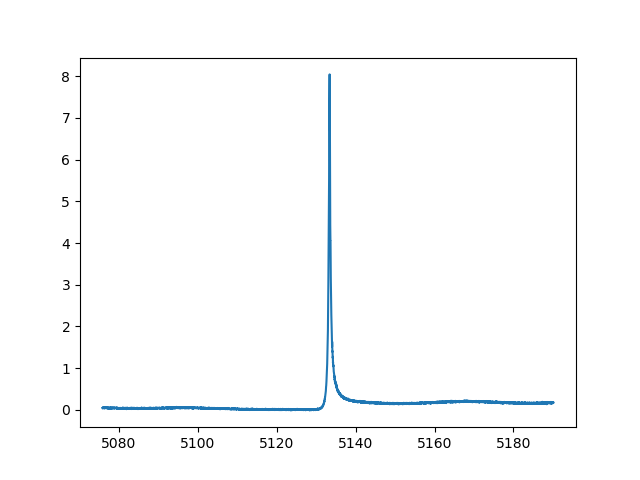

26706.40233658539


In [46]:
plt.figure()
S21_avg = np.mean(S21, axis=1)[p_ind,i_min:i_max] 

plt.plot(freqs, (np.max(S21_avg)-np.abs(S21_avg)) / np.abs(S21_avg))
print(np.max((np.max(np.abs(S21_avg))-np.abs(S21_avg)) / np.abs(S21_avg)) * pars['Qc'].value)